# CAP 6618 - Machine Learning for Computer Vision

Christian Garbin
Spring 2019

# Programming Project 4
See guidelines on Canvas for details.

## Step 1: Setup

First, make sure that you have installed Keras on your computer.

In [3]:
# Code adapted from https://towardsdatascience.com/transfer-learning-using-keras-d804b2e04ef8

from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

/var/web_services/galaxy/jupyter_conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Set up `matplotlib`, used in a few places below.

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Step 2: Classify images using a pretrained (on ImageNet) model (ResNet50)

In [20]:
# Code adapted from https://keras.io/applications/#resnet50

from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

model = ResNet50(weights='imagenet')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

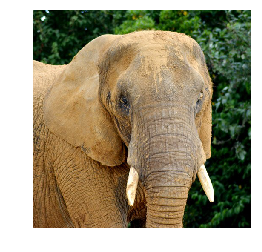

Predicted: [('n02504458', 'African_elephant', 0.875683), ('n01871265', 'tusker', 0.073503256), ('n02504013', 'Indian_elephant', 0.050809734)]


In [22]:
# Code adapted from https://keras.io/applications/#resnet50

img_path = 'elephant.jpg' #image available on Canvas
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

img=mpimg.imread(img_path)
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=3)[0])

## Step 2.1 Try with other images

Keras' ResNet50 model is trained on ImageNet. Image has a collection of [categories and subcategories](http://www.image-net.org/about-stats). In this test we will attempt some (to me) unusual categories. In each case we will try a nice and clean picture (only that category), then a more complicated case, where more objects are part of the picture.

First, some auxiliary functions, based on the code above.

These images were chosen to try to stretch the classifier, and in some cases it did. To make it perform better we should probably first segment the image.

In [37]:
def predict_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return preds

def show_image(img_path):
    img = mpimg.imread(img_path)
    imgplot = plt.imshow(img)
    plt.axis('off')
    plt.show()
    

Now show and classify some images.

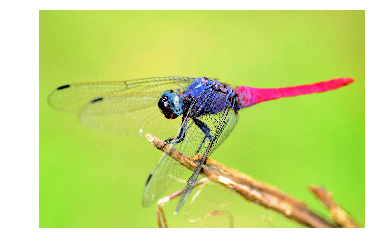

Predicted: [('n02268443', 'dragonfly', 0.986628), ('n02268853', 'damselfly', 0.011298204), ('n02190166', 'fly', 0.0014073297)]


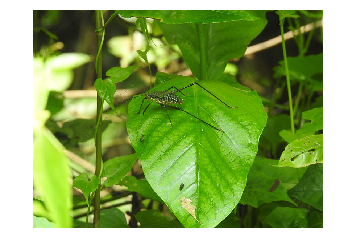

Predicted: [('n01770081', 'harvestman', 0.75791556), ('n02168699', 'long-horned_beetle', 0.08264863), ('n02165105', 'tiger_beetle', 0.028611973)]


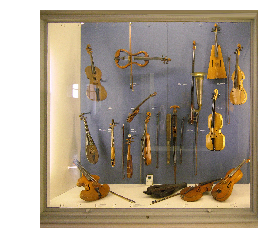

Predicted: [('n04090263', 'rifle', 0.32846463), ('n04086273', 'revolver', 0.27561277), ('n03954731', 'plane', 0.10187672)]


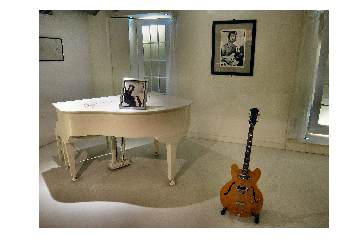

Predicted: [('n04553703', 'washbasin', 0.27778184), ('n04493381', 'tub', 0.13703257), ('n02992211', 'cello', 0.11931717)]


In [38]:
# All images from https://commons.wikimedia.org/wiki/Main_Page
image_paths = [
    # Searched from 'invertebrate'
    # https://commons.wikimedia.org/wiki/File:The_invertebrate.jpg
    # There is only one invertebrate in the picture
    './resnet_test_images/The_invertebrate.jpg',
    # https://commons.wikimedia.org/wiki/File:Invertebrate_Tettigoniidae_(Katydid)_04.jpg
    # Here we have two: lots of plants (leaves) and a bettle
    './resnet_test_images/800px-Invertebrate_Tettigoniidae_(Katydid)_04.jpg',
    
    # Searched for 'classic music instrument'
    # https://commons.wikimedia.org/wiki/File:Special_Shape_Violins_-_Deutsches_Museum_(121281640%2B121281770).jpg
    # Lots of the same instrument
    './resnet_test_images/1920px-Special_Shape_Violins_-_Deutsches_Museum_(121281640+121281770).jpg',
    # https://commons.wikimedia.org/wiki/File:Imagine_room_replica_of_the_Beatles_Story_museum(3).jpg
    # Two instruments in a nice and clean setting
    './resnet_test_images/Imagine_room_replica_of_the_Beatles_Story_museum(3).jpg'
]

for i in image_paths:
    show_image(i)
    print('Predicted:', decode_predictions(predict_image(i), top=3)[0])

## Step 3: Load (and split) the dataset

In [4]:
# Code adapted from https://keras.io/datasets/         and 
# https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py

from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [5]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


## Step 4: Visualize a sample of the CIFAR-10 dataset

In [6]:
# See code at https://github.com/rnoxy/cifar10-cnn/blob/master/CIFAR10-visualization.ipynb    and
# http://parneetk.github.io/blog/cnn-cifar10/      for ideas

## Step 5: Classify images using a CNN built from scratch ("Solution 1")

In [7]:
# Code adapted from https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py

from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

batch_size = 32
num_classes = 10
epochs = 10
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255


print('Not using data augmentation.')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          shuffle=True)

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Not using data augmentation.
Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 170s 3ms/step - loss: 1.8165 - acc: 0.3322 - val_loss: 1.5412 - val_acc: 0.4482
Epoch 2/10
20480/50000 [===========>..................] - ETA: 1:34 - loss: 1.5390 - acc: 0.4426

KeyboardInterrupt: 

## Step 6 (OPTIONAL): Write code to perform image classification using the weights of a CNN pretrained on the CIFAR-10 dataset "as is" and evaluate it on the CIFAR-10 test set

Suggestions:
1. Download _cifar10vgg.h5_ file available at https://github.com/geifmany/cifar-vgg
2. Look at example at https://keras.io/applications  

## Step 7: Write code to perform data augmentation and evaluate its performance on the CIFAR-10 test set ("Solution 2")

## Step 8: Write code to use a pretrained CNN model in which an appropriate (fully-connected) layer's activations are used as features, which are then used by a conventional machine learning classifier ("Solution 3")

In [5]:
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
from keras.models import Model
import numpy as np

base_model = VGG19(weights='imagenet')
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

The code below uses a VGG19 pre-trained on ImageNet and builds a model whose output is the output of the 'fc2' layer of the original (base) model.  

It then demonstrates how one can run an image through the network and extract a (4096-D) feature vector, effectively using the pre-trained CNN as a "de luxe feature extraction step."

Your job is to change the code below to make all images of the training set undergo the same feature extraction step, and use the resulting feature vectors as input to a conventional classfier.

Once the new classifier has been trained, it should be tested on the test set in the usual way.

In [9]:
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)

img_path = 'elephant.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

fc2_features = model.predict(x)
fc2_features.shape

(1, 4096)

## Step 9: Write code to use a pretrained CNN model with the proper modifications (and retraining) to one or more layers ("Solution 4")

## Step 10: Build your best solution (and explain each step) 

## Use a separate notebook